In [132]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from ngram import *
from baselines import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Annotated Data

In [135]:
data_filename  = '../data/v4_annotated/annotated_onion_layer_5_rows_0_to_5000_raters_20.csv'
d_b = load_cf_labels(data_filename)

data_filename  = '../data/v4_annotated/annotated_random_data_rows_0_to_5000_raters_20.csv'
d_r = load_cf_labels(data_filename)

In [136]:
l_b = d_b.groupby('rev_id')['aggression_score'].mean().dropna()
l_r = d_r.groupby('rev_id')['aggression_score'].mean().dropna()

In [137]:
data_b = get_labeled_comments(d_b, l_b)
data_r = get_labeled_comments(d_r, l_r)

### NGram Regression Pipeline

In [94]:
cv_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2')),
    ('clf', Ridge()),
])

In [95]:
param_grid = {
    #'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (None,), #(None, 5000, 10000, 50000),
    'vect__ngram_range': ((1,6),(1,5)),  # unigrams or bigrams
    #'vect_lowercase': (True, False),
    'vect__analyzer' : ('char',), #('word', 'char')
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': (0.01, 0.1, 0.5)
}

#### Blocked Data Set


Best parameters set found:
{'vect__ngram_range': (1, 5), 'vect__analyzer': 'char', 'clf__alpha': 0.1, 'vect__max_features': None} -0.0957710006683


Grid scores:
-0.09790 (+/-0.00000) for {'vect__ngram_range': (1, 6), 'vect__analyzer': 'char', 'clf__alpha': 0.01, 'vect__max_features': None}
-0.09654 (+/-0.00000) for {'vect__ngram_range': (1, 5), 'vect__analyzer': 'char', 'clf__alpha': 0.01, 'vect__max_features': None}
-0.09764 (+/-0.00000) for {'vect__ngram_range': (1, 6), 'vect__analyzer': 'char', 'clf__alpha': 0.1, 'vect__max_features': None}
-0.09577 (+/-0.00000) for {'vect__ngram_range': (1, 5), 'vect__analyzer': 'char', 'clf__alpha': 0.1, 'vect__max_features': None}
-0.10137 (+/-0.00000) for {'vect__ngram_range': (1, 6), 'vect__analyzer': 'char', 'clf__alpha': 0.5, 'vect__max_features': None}
-0.09898 (+/-0.00000) for {'vect__ngram_range': (1, 5), 'vect__analyzer': 'char', 'clf__alpha': 0.5, 'vect__max_features': None}


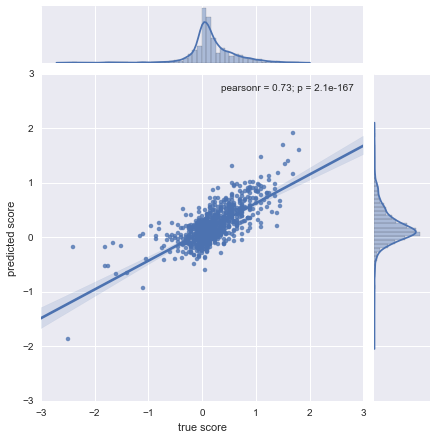

In [105]:
train, test = split(data_b)
model = tune (train['x'], train['y'], cv_pipeline, param_grid, 'mean_squared_error', n_jobs=8, verbose=True)
_ = evaluate(model, test, pearson, plot = True)

#### Random Data Set


Best parameters set found:
{'vect__ngram_range': (1, 5), 'vect__analyzer': 'char', 'clf__alpha': 0.1, 'vect__max_features': None} -0.0957710006683


Grid scores:
-0.09790 (+/-0.00000) for {'vect__ngram_range': (1, 6), 'vect__analyzer': 'char', 'clf__alpha': 0.01, 'vect__max_features': None}
-0.09654 (+/-0.00000) for {'vect__ngram_range': (1, 5), 'vect__analyzer': 'char', 'clf__alpha': 0.01, 'vect__max_features': None}
-0.09764 (+/-0.00000) for {'vect__ngram_range': (1, 6), 'vect__analyzer': 'char', 'clf__alpha': 0.1, 'vect__max_features': None}
-0.09577 (+/-0.00000) for {'vect__ngram_range': (1, 5), 'vect__analyzer': 'char', 'clf__alpha': 0.1, 'vect__max_features': None}
-0.10137 (+/-0.00000) for {'vect__ngram_range': (1, 6), 'vect__analyzer': 'char', 'clf__alpha': 0.5, 'vect__max_features': None}
-0.09898 (+/-0.00000) for {'vect__ngram_range': (1, 5), 'vect__analyzer': 'char', 'clf__alpha': 0.5, 'vect__max_features': None}


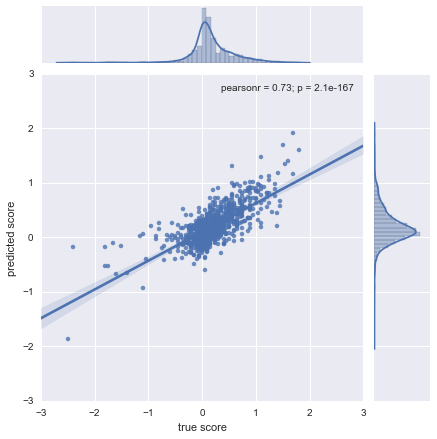

In [104]:
train, test = split(data_r)
model = tune (train['x'], train['y'], cv_pipeline, param_grid, 'mean_squared_error', n_jobs=8, verbose=True)
_ = evaluate(model, test, pearson, plot = True)

In [100]:
optimal_pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range = (1,6))),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2')),
    ('clf', Ridge(alpha = 0.01)),
])

### Finding the Optimal Blend

Keep size of training data fixed. Vary proportion of blocked and random data in training. Eval the blend on held out data from blocked and random.

In [109]:
alphas, b, r = eval_blended_training(optimal_pipeline, data_blocked, data_random, pearson)

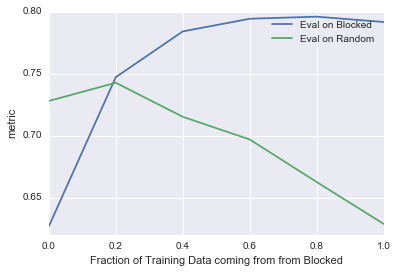

In [110]:
plot_blended_training(alphas, b, r)

### Does adding random data improve prediction on blocked data?

Incrementally add random data to full blocked data set on training. Eval on held out blocked data.

In [127]:
ms, metrics = eval_adding_other_data(optimal_pipeline, data_b, data_r, pearson)

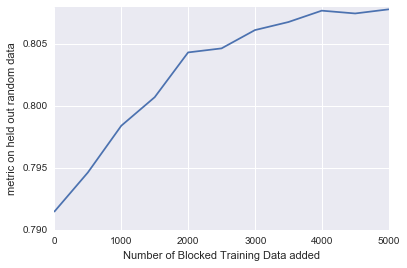

In [128]:
plot_adding_other_data(ms, metrics)

### Does adding blocked data improve prediction on random data?

Incrementally add blocked data to full random data set on training. Eval on held out random data.

In [129]:
ms, metrics = eval_adding_other_data(pipeline, data_random, data_blocked, pearson)

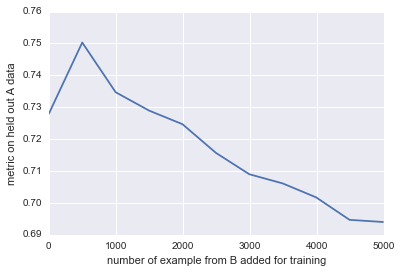

In [138]:
plot_adding_other_data(ms, metrics)

# Final Model

In [143]:
data = pd.concat([data_r,data_b[:500]] )
model = optimal_pipeline.fit(data['x'], data['y'])
joblib.dump(model, '../models/aggression_ngram.pkl')

['../models/aggression_ngram.pkl',
 '../models/aggression_ngram.pkl_01.npy',
 '../models/aggression_ngram.pkl_02.npy',
 '../models/aggression_ngram.pkl_03.npy',
 '../models/aggression_ngram.pkl_04.npy']